Install minimal required dependencies.

In [128]:
import sys
sys.path.append(".")

# also disable grad to save memory
import torch
torch.set_grad_enabled(False)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Define some loading utilities

In [129]:
import yaml
import torch
from omegaconf import OmegaConf
from taming.models.vqgan import VQModel, GumbelVQ

def load_config(config_path, display=False):
  config = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config)))
  return config

def load_vqgan(config, ckpt_path=None, is_gumbel=False):
  if is_gumbel:
    model = GumbelVQ(**config.model.params)
  else:
    model = VQModel(**config.model.params)
  if ckpt_path is not None:
    sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(sd, strict=False)
  return model.eval()

def preprocess_vqgan(x):
  x = 2.*x - 1.
  return x

def custom_to_pil(x):
  x = x.detach().cpu()
  x = torch.clamp(x, -1., 1.)
  x = (x + 1.)/2.
  x = x.permute(1,2,0).numpy()
  x = (255*x).astype(np.uint8)
  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

def reconstruct_with_vqgan(x, model):
  # could also use model(x) for reconstruction but use explicit encoding and decoding here
  z, _, [_, _, indices] = model.encode(x)
  print(f"VQGAN --- {model.__class__.__name__}: latent shape: {z.shape[2:]}")
  xrec = model.decode(z)
  return xrec

In [130]:
import importlib
def get_obj_from_str(string, reload=False):
    module, cls = string.rsplit(".", 1)
    if reload:
        module_imp = importlib.import_module(module)
        importlib.reload(module_imp)
    return getattr(importlib.import_module(module, package=None), cls)

def instantiate_from_config(config):

    if not "target" in config:
        raise KeyError("Expected key `target` to instantiate.")
    return get_obj_from_str(config["target"])(**config.get("params", dict()))

def load_model_from_config(config, sd, gpu=True, eval_mode=True):
    model = instantiate_from_config(config)
    if sd is not None:
        model.load_state_dict(sd)
    if gpu:
        model.cuda()
    if eval_mode:
        model.eval()
    return {"model": model}


def load_model(config, ckpt, gpu, eval_mode):
    # load the specified checkpoint
    if ckpt:
        pl_sd = torch.load(ckpt, map_location="cpu")
        global_step = pl_sd["global_step"]
        print(f"loaded model from global step {global_step}.")
    else:
        pl_sd = {"state_dict": None}
        global_step = None
    model = load_model_from_config(config.model, pl_sd["state_dict"], gpu=gpu, eval_mode=eval_mode)["model"]
    return model, global_step

In [131]:
# config16384 = load_config("logs/vqgan_imagenet_f16_16384/configs/model.yaml", display=False)
import taming
import glob
# conf_path = "logs/2021-04-23T18-11-19_celebahq_transformer/configs/2021-04-23T18-11-19-project.yaml"
conf_path = "./unwrapped.yaml"
ckpt_path = "logs/2021-04-23T18-11-19_celebahq_transformer/checkpoints/last.ckpt"
# ckpt_path = "./faceshq/faceshq.pt"
# conf_path = "./faceshq/faceshq.yaml"

config = load_config(conf_path, display=False)
model = taming.models.vqgan.VQModel(**config.model.params)
sd = torch.load("./vqgan_only.pt", map_location="mps")
model.load_state_dict(sd, strict=True)
model.to("mps")
# model1024, _ = load_model(config, ckpt_path, gpu=False, eval_mode=True)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


VQModel(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        

In [132]:
import io
import os, sys
import requests
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from IPython.display import display, display_markdown

def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))


def preprocess(img, target_image_size=256, map_dalle=True):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return img




def stack_reconstructions(input, x0, x1, x2, x3, titles=[]):
  assert input.size == x1.size == x2.size == x3.size
  w, h = input.size[0], input.size[1]
  img = Image.new("RGB", (5*w, h))
  img.paste(input, (0,0))
  img.paste(x0, (1*w,0))
  img.paste(x1, (2*w,0))
  img.paste(x2, (3*w,0))
  img.paste(x3, (4*w,0))
  for i, title in enumerate(titles):
    ImageDraw.Draw(img).text((i*w, 0), f'{title}', (255, 255, 255), font=font) # coordinates, text, color, font
  return img

Load the provided encoder and decoder.

/var/folders/qt/vykvb40j3832fvsqvsz34prh0000gn/T/ipykernel_25179/3564736018.py:30: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


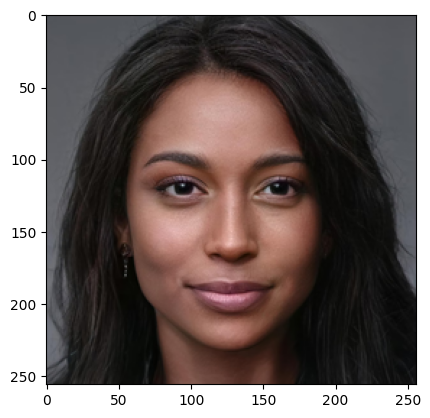

In [133]:
x = preprocess(PIL.Image.open("./test_data/face.jpeg"), target_image_size=256, map_dalle=False)
y = preprocess(PIL.Image.open("./test_data/face2.jpeg"), target_image_size=256, map_dalle=False)
from matplotlib import pyplot as plt
x.shape
plt.imshow(x.permute(0, 2, 3, 1)[0])


## Reconstruct some images

Define the reconstruction pipeline and stack the reconstructions for a direct comparison.

Let's reconstruct some images from the [DIV2K](https://data.vision.ee.ethz.ch/cvl/DIV2K/) dataset.

In [134]:
DEVICE = "mps"
from pyparsing.helpers import ParseExpression
print(x.shape)
print(DEVICE)
x = x.to(DEVICE)
x_processed = preprocess_vqgan(x)
print(x_processed.shape)
x0 = reconstruct_with_vqgan(x_processed, model)
y = y.to(DEVICE)
y_processed = preprocess_vqgan(y)

torch.Size([1, 3, 256, 256])
mps
torch.Size([1, 3, 256, 256])
VQGAN --- VQModel: latent shape: torch.Size([16, 16])


In [135]:
x_latent, _, [_, _, indices] = model.encode(x_processed)
y_latent, _, [_, _, indices]  = model.encode(y_processed)

In [136]:
def get_latent_from_path(path, model):
	DEVICE = "mps"
	x = preprocess(PIL.Image.open(path), target_image_size=256, map_dalle=False)
	
	x = x.to(DEVICE)

	x_processed = preprocess_vqgan(x)
	x_latent, _, [_, _, indices] = model.encode(x_processed)
	return x_latent
	

In [152]:
def slerp(t, v0, v1, DOT_THRESHOLD=0.9995):
    '''
    Spherical linear interpolation
    Args:
        t (float/np.ndarray): Float value between 0.0 and 1.0
        v0 (np.ndarray): Starting vector
        v1 (np.ndarray): Final vector
        DOT_THRESHOLD (float): Threshold for considering the two vectors as
                               colineal. Not recommended to alter this.
    Returns:
        v2 (np.ndarray): Interpolation vector between v0 and v1
    '''
    c = False
    if not isinstance(v0,np.ndarray):
        c = True
        v0 = v0.detach().cpu().numpy()
    if not isinstance(v1,np.ndarray):
        c = True
        v1 = v1.detach().cpu().numpy()
    # Copy the vectors to reuse them later
    v0_copy = np.copy(v0)
    v1_copy = np.copy(v1)
    # Normalize the vectors to get the directions and angles
    v0 = v0 / np.linalg.norm(v0)
    v1 = v1 / np.linalg.norm(v1)
    # Dot product with the normalized vectors (can't use np.dot in W)
    dot = np.sum(v0 * v1)
    # If absolute value of dot product is almost 1, vectors are ~colineal, so use lerp
    if np.abs(dot) > DOT_THRESHOLD:
        print("asdfadsf")
        return lerp(t, v0_copy, v1_copy)
    # Calculate initial angle between v0 and v1
    theta_0 = np.arccos(dot)
    sin_theta_0 = np.sin(theta_0)
    # Angle at timestep t
    theta_t = theta_0 * t
    sin_theta_t = np.sin(theta_t)
    # Finish the slerp algorithm
    s0 = np.sin(theta_0 - theta_t) / sin_theta_0
    s1 = sin_theta_t / sin_theta_0
    v2 = s0 * v0_copy + s1 * v1_copy
    if c:
        res = torch.from_numpy(v2).to("mps")
    else:
        res = v2
    return res

/var/folders/qt/vykvb40j3832fvsqvsz34prh0000gn/T/ipykernel_25179/3564736018.py:30: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)


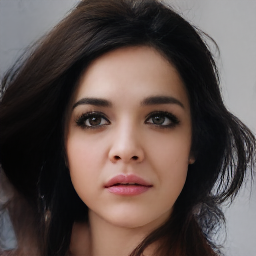

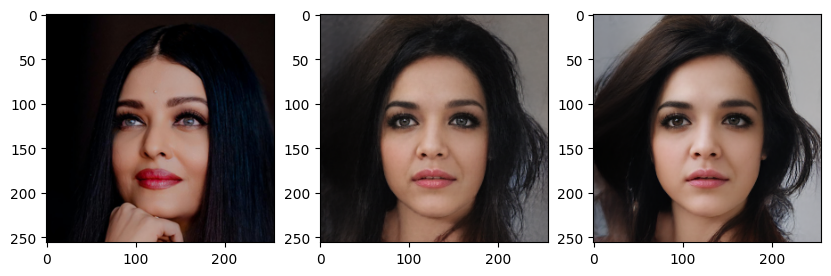

In [154]:
x = get_latent_from_path("./women_aligned/1.png", model)
y = get_latent_from_path("./women_aligned/2.png", model)
v1 = blend(model, "./women_aligned/1.png", "./women_aligned/2.png")


v2 = slerp(.7, x, y)
show_latent(v2)



In [137]:
src2 = PIL.Image.open("./test_data/face2.jpeg")
biglip, normal, smalllip = [get_latent_from_path(x, model).cpu() for x in ["./test_data/biglip.jpg", "./test_data/face.jpeg", "./test_data/small_lip.jpg"]]

/var/folders/qt/vykvb40j3832fvsqvsz34prh0000gn/T/ipykernel_25179/3564736018.py:30: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)


In [138]:
white, gold, red, brown = [get_latent_from_path(x, model).cpu() for x in ["./test_data/gold.jpg", "./test_data/redhair.jpg", "./test_data/white.jpg", "./test_data/face.jpeg"]]

/var/folders/qt/vykvb40j3832fvsqvsz34prh0000gn/T/ipykernel_25179/3564736018.py:30: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)


In [139]:
green_purple = (gold - white)
v_lip = biglip - smalllip
# torch.save(green_purple, "latent_vectors/green_purple.pt")

In [140]:
red_blue = (red - white)

v_lip = biglip - smalllip
# torch.save(red_blue, "latent_vectors/red_blue.pt")

In [141]:
red_test = (gold - brown)

In [142]:
print(
gender_vector.mean(),
gender_vector.std()
)

tensor(0.0030) tensor(0.3208)


In [143]:
import torch
from torch.autograd import Variable
from sklearn.manifold import TSNE

def tsne(data):
    # convert data to numpy array
    data = data.data.numpy()

    # perform t-SNE
    tsne = TSNE(n_components=3)
    X = tsne.fit_transform(data)

    return X

# generate some random data
data = gender_vector.squeeze()

# perform t-SNE
X = tsne(data)

# plot the results
plt.scatter(X[:, 0], X[:, 1])
plt.show()






/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


ValueError: Found array with dim 3. TSNE expected <= 2.

/var/folders/qt/vykvb40j3832fvsqvsz34prh0000gn/T/ipykernel_25179/4181217554.py:30: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


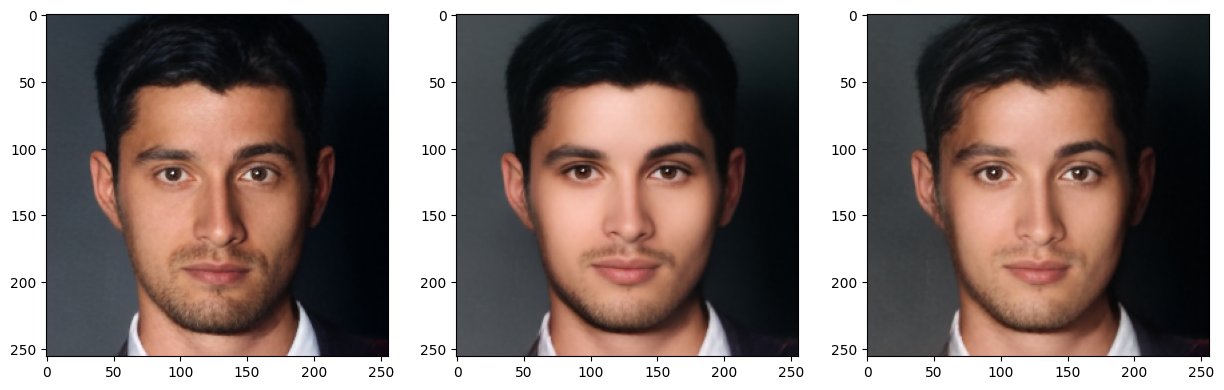

In [ ]:
# v = get_latent_from_path("./test_data/face2.jpeg", model).cpu()
v = get_latent_from_path("./output_men/pexels-pixabay-532220.png", model).cpu()
k = -.8
vec = torch.mean(torch.stack((gender_vector, w_mean)), dim=0)
v_test = torch.lerp(v, v + vec, k)
v_test2 = torch.lerp(v, v - w_mean, k)
v_test3 = torch.lerp(v, v + gender_vector, k)
# v_test2 = model.quantize(v.to("mps"))[0k]
dec2 = model.decode(v_test2.to("mps"))
dec3 = model.decode(v_test3.to("mps"))
dec = model.decode(v_test.to("mps"))
plt.figure(figsize=(15, 8))
plt.subplot(1, 3, 1)
plt.imshow(custom_to_pil(dec[0]))
plt.subplot(1, 3, 2)
plt.imshow(custom_to_pil(dec2[0]))
plt.subplot(1, 3, 3)
plt.imshow(custom_to_pil(dec3[0]))
plt.show()

/var/folders/qt/vykvb40j3832fvsqvsz34prh0000gn/T/ipykernel_25179/3564736018.py:30: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


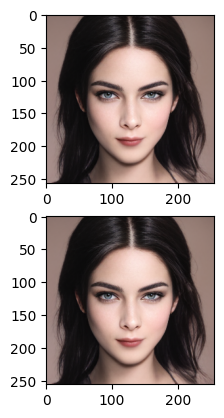

In [144]:
def show_latent(latent):
    dec = model.decode(latent.to("mps"))
    im = custom_to_pil(dec[0])
    plt.imshow(im)
    return im



v = get_latent_from_path("./test_data/face2.jpeg", model).cpu()
k = -1.4
v_test = torch.slerp(v, v + v_lip, k)
v_test2 = torch.lerp(v, v +(k * v_lip), 1)
# v_test = model.quantize(v_test.to("mps"))[0]
dec = model.decode(v_test.to("mps"))
dec2 = model.decode(v_test2.to("mps"))
plt.subplot(2, 1, 1)
plt.imshow(custom_to_pil(dec[0]))
plt.subplot(2, 1, 2)
plt.imshow(custom_to_pil(dec2[0]))

-1.0999999999999999
-0.7999999999999999
-0.4999999999999999
-0.19999999999999996
0.10000000000000009
0.40000000000000013
0.7000000000000002
1.0
1.3000000000000003


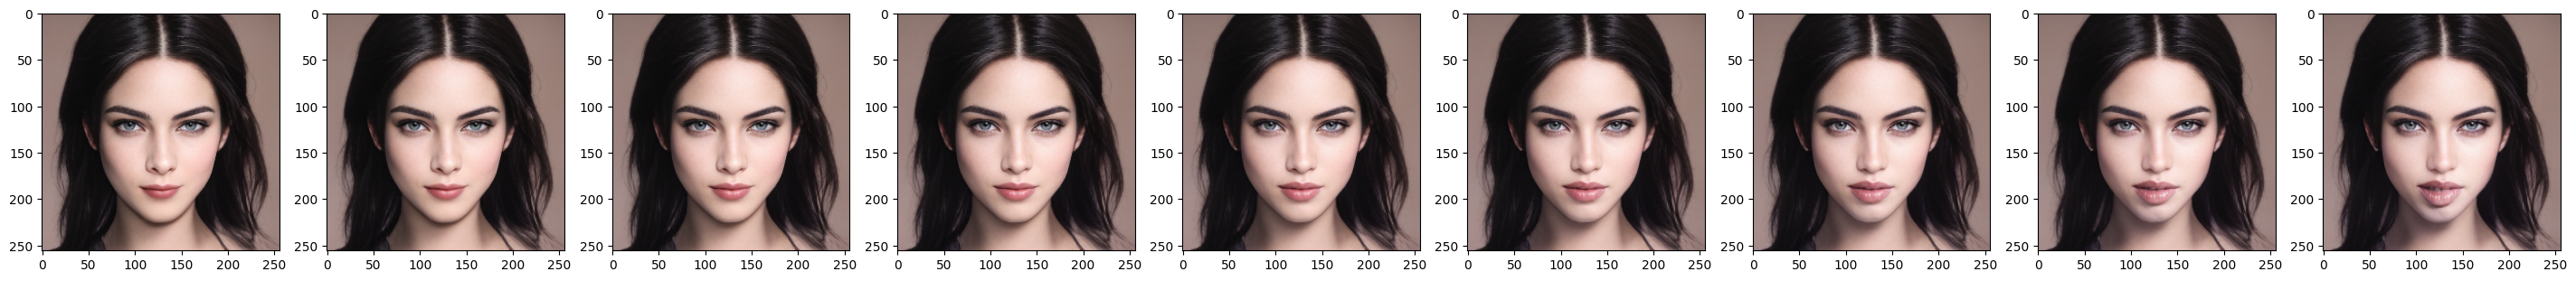

In [ ]:
import math
khdec = model.decode(v_test.to("mps"))
orig = model.decode(v.to("mps"))
plt.figure(figsize=(40, 10))
rows = 10
# plt.subplot(math.ceil(rows//2), rows // 2, 1)
# plt.imshow(custom_to_pil(orig[0]))
for i in range(1, rows):
	weight = -1.4 + (i * 3 /10)
	print(weight)
	v_test = torch.lerp(v, v + v_lip, weight)
	dec = model.decode(v_test.to("mps"))
	plt.subplot(1, rows, i + 1)
	plt.imshow(custom_to_pil(dec[0]))

In [ ]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

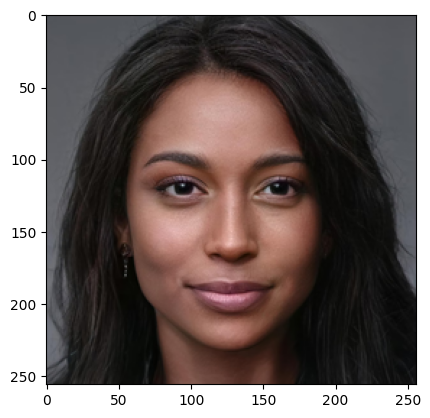

In [ ]:
plt.imshow(x.cpu().permute(0, 2, 3, 1)[0])

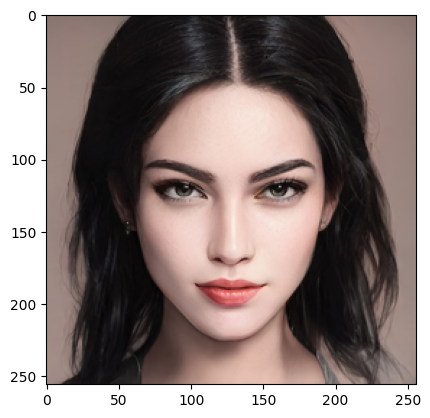

In [ ]:
plt.imshow(y.cpu().permute(0, 2, 3, 1)[0])

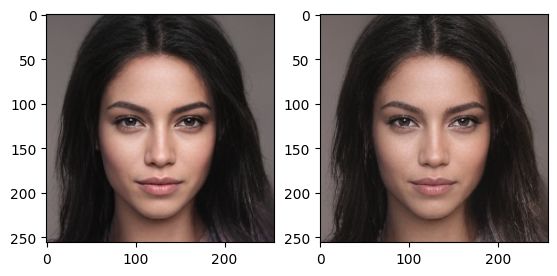

In [ ]:
z = torch.lerp(x_latent.cpu(), y_latent.cpu(), 0.5)
z_quant = model.quantize(z.to("mps"))[0]
decoded = model.decode(z.to("mps"))
q_decoded = model.decode(z_quant.to("mps"))
plt.figure(figsize=(10, 20))
plt.subplot(1, 3, 1)
plt.imshow(custom_to_pil(decoded[0]))
plt.subplot(1, 3, 2)
plt.imshow(custom_to_pil(q_decoded[0]))

In [ ]:
print(torch.std_mean(x_latent.cpu()))
print(torch.std_mean(y_latent.cpu()))
print(torch.std_mean(z.cpu()))



def blend(model, path1, path2, quantize=False, weight=0.5):
	DEVICE = "mps"
	x = preprocess(PIL.Image.open(path1), target_image_size=256, map_dalle=False)
	y = preprocess(PIL.Image.open(path2), target_image_size=256, map_dalle=False)
	x = x.to(DEVICE)
	y = y.to(DEVICE)

	x_processed = preprocess_vqgan(x)
	y_processed = preprocess_vqgan(y)	
	x_latent, _, [_, _, indices] = model.encode(x_processed)
	y_latent, _, [_, _, indices]  = model.encode(y_processed)
	z = torch.lerp(x_latent.cpu(), y_latent.cpu(), weight)
	if quantize:
		z = model.quantize(z.to("mps"))[0]
	decoded = model.decode(z.to("mps"))
	plt.figure(figsize=(10, 20))
	plt.subplot(1, 3, 1)
	plt.imshow(x.cpu().permute(0, 2, 3, 1)[0])
	plt.subplot(1, 3, 2)
	plt.imshow(custom_to_pil(decoded[0]))
	plt.subplot(1, 3, 3)
	plt.imshow(y.cpu().permute(0, 2, 3, 1)[0])
    return z, decoded



(tensor(0.6677), tensor(-0.0281))
(tensor(0.7830), tensor(-0.0084))
(tensor(0.3046), tensor(-0.0895))


In [ ]:
# print(model1024.loss)
# torch.save(model1024.loss.state_dict(), "VQLPIPSandDisc.pt")
import torch
torch.save(gender_vector, "./latent_vectors/gender.pt")

In [ ]:
test = preprocess(PIL.Image.open("./test_data/cloud.jpeg"), target_image_size=256, map_dalle=False)
test_processed = preprocess_vqgan(test)
logits_fake = model1024.loss.discriminator(test_processed.to("mps"))
print(logits_fake.mean())

In [ ]:
import os
import glob
# os.listdir("output_men")
men_paths = glob.glob("./output_men/*")
women_paths = glob.glob("./women_aligned/*")

In [ ]:
# print(men_paths)
w_latents = [get_latent_from_path(x, model).cpu() for x in women_paths]
m_latents = [get_latent_from_path(x, model).cpu() for x in men_paths]
print(m_latents[0].shape)


/var/folders/qt/vykvb40j3832fvsqvsz34prh0000gn/T/ipykernel_25179/4181217554.py:30: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


torch.Size([1, 256, 16, 16])


In [ ]:
m_mean = torch.mean(torch.stack(m_latents), dim=0)
w_mean = torch.mean(torch.stack(w_latents), dim=0)
gender_vector = m_mean - w_mean


torch.Size([1, 256, 16, 16])


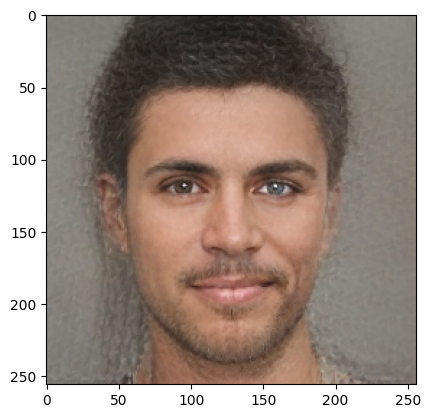

In [ ]:
x = torch.stack(m_latents)
x.shape
y = torch.mean(x, dim=0).to("mps")
print(y.shape)
z = model.decode(y)
plt.imshow(custom_to_pil(z[0].to("mps")))



In [ ]:
# model1024 = model1024.to("mps")
# blend(model1024, "./test_data/face.jpeg", "./test_data/face2.jpeg", quantize=False, weight=.5)

In [ ]:
import math
def trigonometric_interpolation(latent_vector1, latent_vector2, num_steps, amplitude=1.0, frequency=1.0):
  latent_vectors = []
  for step in range(num_steps):
    t = step / (num_steps - 1)
    latent_vector = amplitude * (latent_vector1 * math.cos(2 * math.pi * frequency * t) + latent_vector2 * math.sin(2 * math.pi * frequency * t))
    latent_vectors.append(latent_vector)
  return latent_vectors

# blend(model, "./test_data/face.jpeg", "./test_data/face2.jpeg", quantize=False)
x = get_latent_from_path("./test_data/face.jpeg", model)
y = get_latent_from_path("./test_data/face2.jpeg", model)
l = trigonometric_interpolation(x, y, 10, amplitude=1, frequency=.61)

/var/folders/qt/vykvb40j3832fvsqvsz34prh0000gn/T/ipykernel_25179/4181217554.py:30: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)


In [ ]:
x= list(model.parameters())

In [ ]:
print(len(model.state_dict().named+))


343


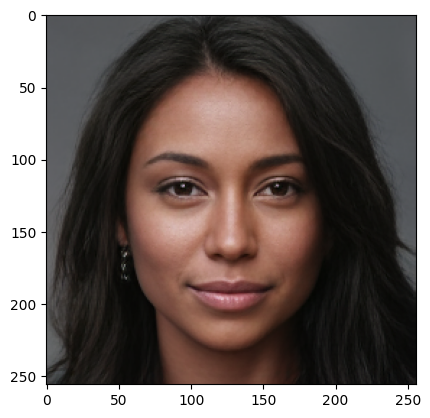

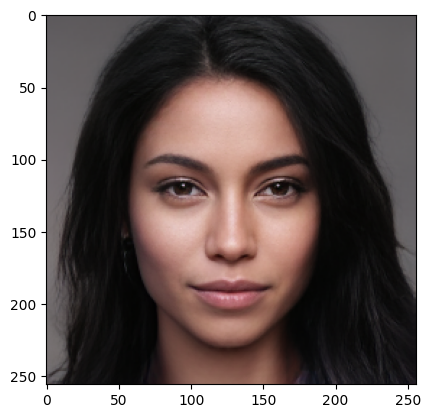

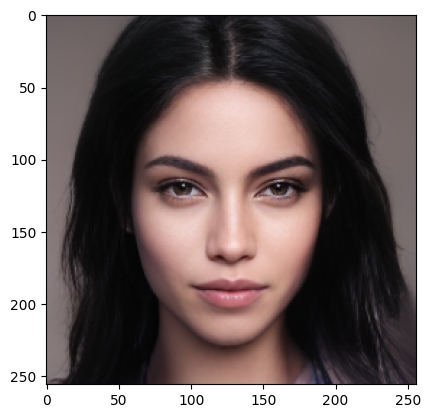

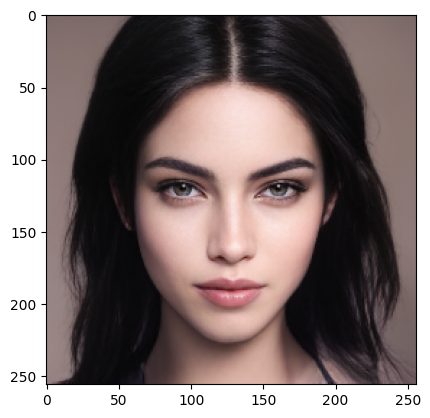

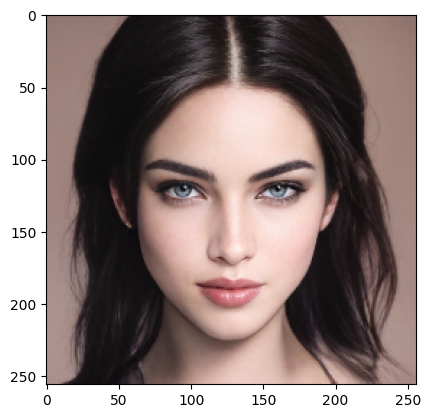

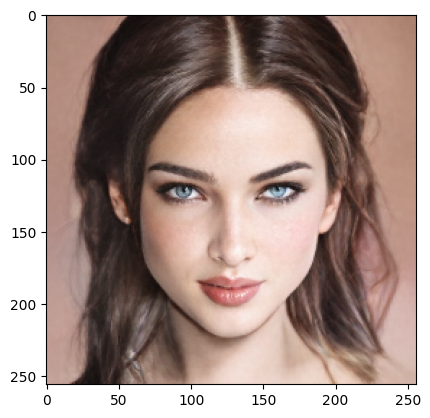

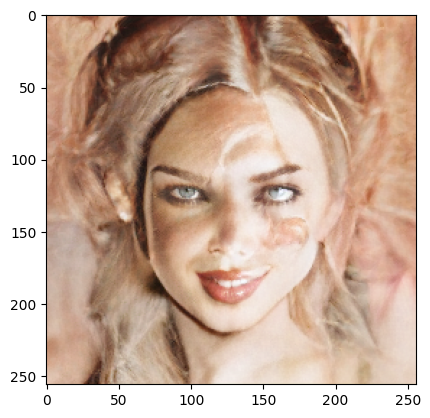

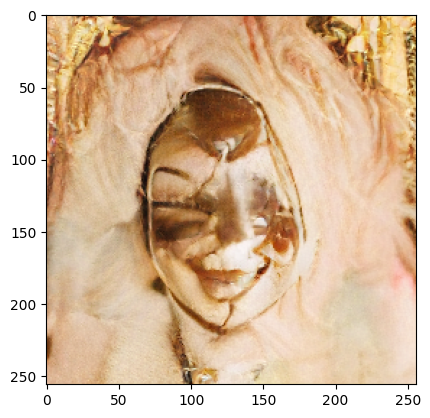

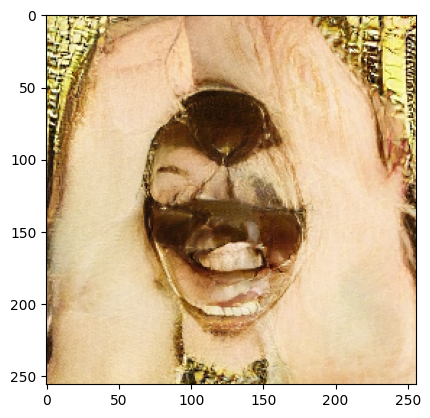

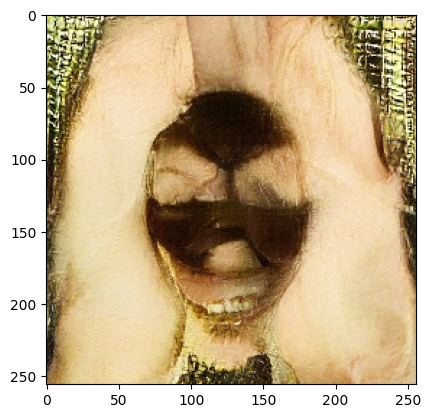

In [ ]:
def decode_and_show(l):
    decoded = model.decode(l)
    plt.imshow(custom_to_pil(decoded[0]))
    plt.show()

for i in l:
    decode_and_show(i)

In [ ]:
# latent.shape

latent, _, [_, _, indices] = model.encode(x_processed)
m = latent[:, 1].mean()
s = latent.std()
print(m, s)
latent[:, :,4,] *= 1
latent[:, 100:120,:,:] *= 10 * s
# print(m, s)
decoded = model.decode(latent)
plt.imshow(custom_to_pil(decoded[0]))


In [ ]:

plt.imshow(x.cpu().permute(0, 2, 3, 1)[0])

In [ ]:
# plt.imshow(x)
plt.imshow(custom_to_pil(x0[0]))

In [ ]:
reconstruction_pipeline(url='https://heibox.uni-heidelberg.de/f/7bb608381aae4539ba7a/?dl=1', size=384)

Especially at regions like the squirrel's fur and tail, the VQGANs produce plausible textures whereas the first stage of DALL-E produces overly smooth regions despite using four times more codes. On the other hand, using fewer codes means that the VQGAN cannot reproduce every detail of its input but instead hallucinates parts of it. In particular, the VQGAN (1024) has difficulties reconstructing the foot, which can be remedied to some degree by the bigger codebook size of VQGAN (16384).

In [ ]:
reconstruction_pipeline(url='https://heibox.uni-heidelberg.de/f/6f12b330eb564d288d76/?dl=1', size=384)

In [ ]:
reconstruction_pipeline(url='https://heibox.uni-heidelberg.de/f/8555a959b0a5423cbfd1/?dl=1', size=384)

In [ ]:
reconstruction_pipeline(url='https://heibox.uni-heidelberg.de/f/be6f4ff34e1544109563/?dl=1', size=384)

Faces are particularly difficult for the VQGAN to get right and the reconstructions of DALL-E's first stage appear more presentable. However, it should also be noted that the latter has been trained on a dataset which is roughly 400 times larger than the dataset (ImageNet) that the VQGAN was trained on. Thus, training the VQGAN on a larger dataset, or fine-tuning it on a dataset containing more faces, could improve the perceptual quality of reconstructed faces (and VQGANs trained on face datasets only do not show this problem).

In [ ]:
reconstruction_pipeline("https://heibox.uni-heidelberg.de/f/e41f5053cbd34f11a8d5/?dl=1", size=384)

And finally, the penguin.

In [ ]:
reconstruction_pipeline(url='https://assets.bwbx.io/images/users/iqjWHBFdfxIU/iKIWgaiJUtss/v2/1000x-1.jpg', size=384)

## Conclusion

These examples show that the use of an adversarial loss applied in a patch-wise manner does indeed help to produce reconstructions that favor *realism* over a perfect reconstruction (but may cause "deletion" of certain objects, such as the pine cone in the 4th example). Furthermore, the adversarial training enables very agressive downsampling: Given an image of size $256 \times 256$, the VQGAN produces a sequence of length $16 \cdot 16 = 256$ (vs. $32 \cdot 32 = 1024$ for DALL-E). This supports downstream tasks such as training attention-based models on the latent space, which, in their basic form, scale quadratically with sequence length. Thus, training the same transformer on top of the codes produced by the VQGAN is roughly 16 times faster than training it on top of DALL-E's first stage.

We also observe that a more realistic and faithful reconstruction can be achieved if $\vert \mathcal{Z} \vert$ is increased or the compression rate is decreased (f8-model). Note, however, that a lower latent dimensionality can also help a downstream autoregressive likelihood model (such as our transformer) to generate more globally coherent structures and descreases training cost.


One way to quantify the amount of "realism" captured by these models is to compute FID scores of reconstructed images w.r.t. the inputs (R-FIDs). The following table shows R-FIDs when reconstructing the validation split of the ImageNet dataset ($256 \times 256$ px images). Additionally, we also evaluate the perceptual similarity between inputs and reconstructions with the [LPIPS](https://richzhang.github.io/PerceptualSimilarity/) metric and structural similarity through PSNR and SSIM.


|   | VQGAN f16 (16384) |  VQGAN f16 (1024)  |  DALL-E f8 (8192)| VQGAN f8 (8192)|
|---| :---:| :---: | :---: | :---: |
| R-FID 	$\downarrow$ | 4.98 | 7.94 | 32.01 | 1.49 |
| LPIPS 	$\downarrow$ | 1.83 +/- 0.42 | 1.98 +/- 0.43 | 1.95 +/- 0.51 | 1.17 +/- 0.34 |
| PSNR 	$\uparrow$ | 19.9 +/- 3.4 | 19.4 +/- 3.3 | 22.8 +/- 2.1 | 22.2 +/- 3.8 |
| SSIM 	$\uparrow$ | 0.51 +/- 0.18 | 0.50 +/- 0.18 | 0.73 +/- 0.13 | 0.65 +/- 0.16 |



Finally, note that these models can be used in a fully convolutional fashion: For an input of size $(h, w)$, the corresponding latent representation is always $(h/2^m, w/2^m)$, with $m=4$ for the VQGANs presented here and $m=3$ for the autoencoder of DALL-E. 

In [ ]:
display(reconstruction_pipeline("https://heibox.uni-heidelberg.de/f/5cfd15de5d104d6fbce4/?dl=1", size=320))
display(reconstruction_pipeline("https://heibox.uni-heidelberg.de/f/5cfd15de5d104d6fbce4/?dl=1", size=512))